In [ ]:
!pip install -U spacy==3.*
!python -m spacy download en_core_web_sm
!python -m spacy info
!pip install sastrawi


In [ ]:
# Upgrade gensim in case.
# !pip install --upgrade numpy
!pip install -U gensim==4.*

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import regex as re
import pickle
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from gensim import models, corpora
from gensim import similarities
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud


In [ ]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\tengk\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


1. Input Data

In [26]:
cnn = pd.read_csv(r'C:\Users\tengk\Downloads\dataset-20231116T231847Z-001\dataset\resesi_cnn (1).csv')
detik = pd.read_csv(r'C:\Users\tengk\Downloads\dataset-20231116T231847Z-001\dataset\resesi_detik (2).csv')
antara = pd.read_csv(r'C:\Users\tengk\Downloads\dataset-20231116T231847Z-001\dataset\antaranews.csv')
idntimes = pd.read_excel(r"C:\Users\tengk\Downloads\dataset-20231116T231847Z-001\dataset\resesi_idntimes (1).xlsx")
kompas = pd.read_csv(r"C:\Users\tengk\Downloads\dataset-20231116T231847Z-001\dataset\resesi_Kompas.csv")
cnbc = pd.read_csv(r'C:\Users\tengk\Downloads\dataset-20231116T231847Z-001\dataset\resesi_cnbcindonesia.csv')
antara1 = antara["konten"]
print(antara1)


0       [{"konten":"Tahun ini Solo lolos dua kategori ...
1       [{"konten":"Pertemuan ini intinya membahas kom...
2       [{"konten":"BSN berkomitmen menyelesaikan PED ...
3       [{"konten":"Singapura (ANTARA) - Harga minyak ...
4       [{"konten":"Kami berharap kerja sama ini bisa ...
                              ...                        
1495    [{"konten":"Implikasinya adalah dolar AS dapat...
1496    [{"konten":"Singapura (ANTARA) - Saham Asia na...
1497    [{"konten":"Sydney (ANTARA) - Pasar saham Asia...
1498    [{"konten":"Kami telah membuat kemajuan dalam ...
1499    [{"konten":"Beijing (ANTARA) - Impor dan ekspo...
Name: konten, Length: 1500, dtype: object


In [27]:
antara["tanggal"].head()



0    Selasa, 13 Juni 2023 12:10 WIB
1    Selasa, 13 Juni 2023 17:20 WIB
2    Selasa, 13 Juni 2023 19:17 WIB
3      Rabu, 14 Juni 2023 08:44 WIB
4      Rabu, 14 Juni 2023 12:59 WIB
Name: tanggal, dtype: object

In [28]:
cnn["date"].head()

0    Rabu, 01 Okt 2014 13:28 WIB
1    Rabu, 08 Okt 2014 13:13 WIB
2    Rabu, 29 Okt 2014 15:43 WIB
3    Rabu, 05 Nov 2014 10:30 WIB
4    Rabu, 19 Nov 2014 15:05 WIB
Name: date, dtype: object

In [29]:
detik["tanggal"].head()

0    Kamis, 01 Jun 2023 12:24 WIB
1    Kamis, 01 Jun 2023 19:01 WIB
2    Kamis, 08 Jun 2023 08:02 WIB
3    Kamis, 08 Jun 2023 10:56 WIB
4    Kamis, 08 Jun 2023 13:22 WIB
Name: tanggal, dtype: object

In [30]:
cnbc["tanggal"].unique()

array(['29 August 2019 11:12', '29 August 2019 11:34',
       '29 August 2019 11:53', ..., '02 April 2020 15:10',
       '30 March 2020 10:09', '30 March 2020 10:24'], dtype=object)

In [ ]:
# antara["indikator"] = antara["tanggal"].apply(lambda x: isinstance(x, float))
# antara.loc[antara["indikator"] == True]

In [31]:
def filterTanggal(doc, date):
  docCopy = doc
  docCopy.dropna(axis=0, inplace=True)
  docCopy[date]= docCopy[date].apply(lambda x: int(re.findall("\d{4}", x)[0]))
  return docCopy.loc[docCopy[date] > 2021]

In [32]:
idntimes["tanggal"]

0      05 Apr 22 | 07:45
1      05 Apr 22 | 07:45
2      05 Apr 22 | 07:45
3      29 Apr 22 | 16:54
4      29 Apr 22 | 16:54
             ...        
299    27 May 23 | 10:15
300    27 May 23 | 10:15
301    09 Jun 23 | 08:52
302    09 Jun 23 | 08:52
303    09 Jun 23 | 08:52
Name: tanggal, Length: 304, dtype: object

In [33]:
filterAntara = filterTanggal(antara,"tanggal")
filterCnn = filterTanggal(cnn,"date")
filterDetik = filterTanggal(detik,"tanggal")
filterCnbc = filterTanggal(cnbc,"tanggal")
filterKompas = filterTanggal(kompas,"tanggal")

In [ ]:
print(len(filterCnn))
print(len(filterDetik))
print(len(filterKompas))
print(len(filterAntara))

952
480
297
1475


In [ ]:
1500-1475

25

In [34]:
filterAntara.head()

,web-scraper-order,web-scraper-start-url,page,sub_resesi,sub_resesi-href,judul,konten,tanggal
0,1691552356-1,https://www.antaranews.com/search?q=resesi,https://www.antaranews.com/search?q=resesi&pag...,Destinasi wisata di Solo masuk nominasi API 2023,https://www.antaranews.com/berita/3585402/dest...,Destinasi wisata di Solo masuk nominasi API 2023,"[{""konten"":""Tahun ini Solo lolos dua kategori ...",2023
1,1691552359-2,https://www.antaranews.com/search?q=resesi,https://www.antaranews.com/search?q=resesi&pag...,Negara anggota ASEAN bahas harmonisasi standar...,https://www.antaranews.com/berita/3586107/nega...,Negara anggota ASEAN bahas harmonisasi standar...,"[{""konten"":""Pertemuan ini intinya membahas kom...",2023
2,1691552362-3,https://www.antaranews.com/search?q=resesi,https://www.antaranews.com/search?q=resesi&pag...,BSN komitmen selesaikan PED guna tingkatkan pe...,https://www.antaranews.com/berita/3586416/bsn-...,BSN komitmen selesaikan PED guna tingkatkan pe...,"[{""konten"":""BSN berkomitmen menyelesaikan PED ...",2023
3,1691552365-4,https://www.antaranews.com/search?q=resesi,https://www.antaranews.com/search?q=resesi&pag...,Minyak turun di Asia setelah kenaikan tak terd...,https://www.antaranews.com/berita/3587136/miny...,Minyak turun di Asia setelah kenaikan tak terd...,"[{""konten"":""Singapura (ANTARA) - Harga minyak ...",2023
4,1691552368-5,https://www.antaranews.com/search?q=resesi,https://www.antaranews.com/search?q=resesi&pag...,Menparekraf dukung UNU Yogyakarta cetak wiraus...,https://www.antaranews.com/berita/3587481/menp...,Menparekraf dukung UNU Yogyakarta cetak wiraus...,"[{""konten"":""Kami berharap kerja sama ini bisa ...",2023


In [35]:
filterDetik.head()

,web-scraper-order,web-scraper-start-url,pagination,link-search,link-search-href,judul,isi,tanggal
0,1691148048-1,https://www.detik.com/search/searchall?query=r...,https://www.detik.com/search/searchall?query=r...,"detikFinanceKamis, 01 Jun 2023 12:24 WIB\n ...",https://finance.detik.com/properti/d-6750373/k...,Keuntungan Pindah KPR Bisa Hemat Ratusan Juta,"[{""isi"":""KPR adalah salah satu cara yang dapat...",2023
1,1691148054-2,https://www.detik.com/search/searchall?query=r...,https://www.detik.com/search/searchall?query=r...,"detikFinanceKamis, 01 Jun 2023 19:01 WIB\n ...",https://finance.detik.com/berita-ekonomi-bisni...,RI Mau Bikin Lebih Banyak Perempuan Sukses Jad...,"[{""isi"":""Usaha Mikro Kecil dan Menengah (UMKM)...",2023
2,1691148062-3,https://www.detik.com/search/searchall?query=r...,https://www.detik.com/search/searchall?query=r...,"detikFinanceKamis, 08 Jun 2023 08:02 WIB\n ...",https://finance.detik.com/berita-ekonomi-bisni...,Investasi Emas Pakai Strategi Lump Sum Sejak A...,"[{""isi"":""Emas logam mulai sering dianggap seba...",2023
3,1691148065-4,https://www.detik.com/search/searchall?query=r...,https://www.detik.com/search/searchall?query=r...,"detikFinanceKamis, 08 Jun 2023 10:56 WIB\n ...",https://finance.detik.com/energi/d-6761314/inf...,Inflasi-Utang AS Bikin Harga Minyak Mentah RI ...,"[{""isi"":""Harga minyak mentah Indonesia atau In...",2023
4,1691148072-5,https://www.detik.com/search/searchall?query=r...,https://www.detik.com/search/searchall?query=r...,"detikFinanceKamis, 08 Jun 2023 13:22 WIB\n ...",https://finance.detik.com/berita-ekonomi-bisni...,Bank Dunia Ramal Ekonomi RI Tak Sampai 5% di 2...,"[{""isi"":""Menteri Keuangan (Menkeu) Sri Mulyani...",2023


In [36]:
filterCnn.head()

,web-scraper-order,web-scraper-start-url,paging,main_link_title,main_link_title-href,title,date,isi
929,1697402430-930,https://www.cnnindonesia.com/search/?query=resesi,https://www.cnnindonesia.com/search/?query=res...,EDUKASI KEUANGANTips Milenial Punya Gaji Rp7 J...,https://www.cnnindonesia.com/ekonomi/202112311...,Tips Milenial Punya Gaji Rp7 Juta yang Ingin B...,2022,"Jakarta, CNN Indonesia -- Pemerintah memberika..."
930,1697402433-931,https://www.cnnindonesia.com/search/?query=resesi,https://www.cnnindonesia.com/search/?query=res...,05:37VIDEO: Tantangan Ekonomi Indonesia di 202...,https://www.cnnindonesia.com/tv/20220101134854...,VIDEO: Tantangan Ekonomi Indonesia di 2022,2022,"Jakarta, CNN Indonesia -- Pandemi Covid-19 mem..."
931,1697402437-932,https://www.cnnindonesia.com/search/?query=resesi,https://www.cnnindonesia.com/search/?query=res...,Politikus PDIP Respons Tudingan PKS soal Utang...,https://www.cnnindonesia.com/nasional/20220102...,Politikus PDIP Respons Tudingan PKS soal Utang...,2022,"Jakarta, CNN Indonesia -- Anggota Komisi XI DP..."
932,1697402442-933,https://www.cnnindonesia.com/search/?query=resesi,https://www.cnnindonesia.com/search/?query=res...,"Waspadai Lonjakan Harga Energi, Picu Kerusuhan...",https://www.cnnindonesia.com/ekonomi/202203101...,"Waspadai Lonjakan Harga Energi, Picu Kerusuhan...",2022,"Jakarta, CNN Indonesia -- Kepala Ekonom Bank D..."
933,1697402446-934,https://www.cnnindonesia.com/search/?query=resesi,https://www.cnnindonesia.com/search/?query=res...,Goldman Sachs Prediksi Resesi AS Capai 35 Pers...,https://www.cnnindonesia.com/ekonomi/202203121...,Goldman Sachs Prediksi Resesi AS Capai 35 Pers...,2022,"Jakarta, CNN Indonesia -- Goldman Sachs mempre..."


In [37]:
filterAntara.rename(columns={"konten": "isi"}, inplace=True)
filterAntara.head()

,web-scraper-order,web-scraper-start-url,page,sub_resesi,sub_resesi-href,judul,isi,tanggal
0,1691552356-1,https://www.antaranews.com/search?q=resesi,https://www.antaranews.com/search?q=resesi&pag...,Destinasi wisata di Solo masuk nominasi API 2023,https://www.antaranews.com/berita/3585402/dest...,Destinasi wisata di Solo masuk nominasi API 2023,"[{""konten"":""Tahun ini Solo lolos dua kategori ...",2023
1,1691552359-2,https://www.antaranews.com/search?q=resesi,https://www.antaranews.com/search?q=resesi&pag...,Negara anggota ASEAN bahas harmonisasi standar...,https://www.antaranews.com/berita/3586107/nega...,Negara anggota ASEAN bahas harmonisasi standar...,"[{""konten"":""Pertemuan ini intinya membahas kom...",2023
2,1691552362-3,https://www.antaranews.com/search?q=resesi,https://www.antaranews.com/search?q=resesi&pag...,BSN komitmen selesaikan PED guna tingkatkan pe...,https://www.antaranews.com/berita/3586416/bsn-...,BSN komitmen selesaikan PED guna tingkatkan pe...,"[{""konten"":""BSN berkomitmen menyelesaikan PED ...",2023
3,1691552365-4,https://www.antaranews.com/search?q=resesi,https://www.antaranews.com/search?q=resesi&pag...,Minyak turun di Asia setelah kenaikan tak terd...,https://www.antaranews.com/berita/3587136/miny...,Minyak turun di Asia setelah kenaikan tak terd...,"[{""konten"":""Singapura (ANTARA) - Harga minyak ...",2023
4,1691552368-5,https://www.antaranews.com/search?q=resesi,https://www.antaranews.com/search?q=resesi&pag...,Menparekraf dukung UNU Yogyakarta cetak wiraus...,https://www.antaranews.com/berita/3587481/menp...,Menparekraf dukung UNU Yogyakarta cetak wiraus...,"[{""konten"":""Kami berharap kerja sama ini bisa ...",2023


In [38]:
filterCnn.rename(columns={"title": "judul","date":"tanggal"}, inplace=True)
filterCnn.head()

C:\Users\tengk\AppData\Local\Temp\ipykernel_22708\2133179161.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterCnn.rename(columns={"title": "judul","date":"tanggal"}, inplace=True)


,web-scraper-order,web-scraper-start-url,paging,main_link_title,main_link_title-href,judul,tanggal,isi
929,1697402430-930,https://www.cnnindonesia.com/search/?query=resesi,https://www.cnnindonesia.com/search/?query=res...,EDUKASI KEUANGANTips Milenial Punya Gaji Rp7 J...,https://www.cnnindonesia.com/ekonomi/202112311...,Tips Milenial Punya Gaji Rp7 Juta yang Ingin B...,2022,"Jakarta, CNN Indonesia -- Pemerintah memberika..."
930,1697402433-931,https://www.cnnindonesia.com/search/?query=resesi,https://www.cnnindonesia.com/search/?query=res...,05:37VIDEO: Tantangan Ekonomi Indonesia di 202...,https://www.cnnindonesia.com/tv/20220101134854...,VIDEO: Tantangan Ekonomi Indonesia di 2022,2022,"Jakarta, CNN Indonesia -- Pandemi Covid-19 mem..."
931,1697402437-932,https://www.cnnindonesia.com/search/?query=resesi,https://www.cnnindonesia.com/search/?query=res...,Politikus PDIP Respons Tudingan PKS soal Utang...,https://www.cnnindonesia.com/nasional/20220102...,Politikus PDIP Respons Tudingan PKS soal Utang...,2022,"Jakarta, CNN Indonesia -- Anggota Komisi XI DP..."
932,1697402442-933,https://www.cnnindonesia.com/search/?query=resesi,https://www.cnnindonesia.com/search/?query=res...,"Waspadai Lonjakan Harga Energi, Picu Kerusuhan...",https://www.cnnindonesia.com/ekonomi/202203101...,"Waspadai Lonjakan Harga Energi, Picu Kerusuhan...",2022,"Jakarta, CNN Indonesia -- Kepala Ekonom Bank D..."
933,1697402446-934,https://www.cnnindonesia.com/search/?query=resesi,https://www.cnnindonesia.com/search/?query=res...,Goldman Sachs Prediksi Resesi AS Capai 35 Pers...,https://www.cnnindonesia.com/ekonomi/202203121...,Goldman Sachs Prediksi Resesi AS Capai 35 Pers...,2022,"Jakarta, CNN Indonesia -- Goldman Sachs mempre..."


In [39]:
# filterCnn["date"].unique()
filterKompas.rename(columns={"konten":"isi"}, inplace=True)
filterKompas.head()

,web-scraper-order,web-scraper-start-url,paging,sub_resesi,sub_resesi-href,judul,isi,tanggal
0,1700115575-1,https://www.kompas.com/tag/resesi?page=26,https://www.kompas.com/tag/resesi?page=25,Harga Minyak Mentah Naik di Tengah Kekhawatira...,http://money.kompas.com/read/2022/07/09/081000...,Harga Minyak Mentah Naik di Tengah Kekhawatira...,"[{""konten"":""LONDON, KOMPAS.com – Harga minyak ...",2022
1,1700115596-2,https://www.kompas.com/tag/resesi?page=26,https://www.kompas.com/tag/resesi?page=25,"Probabilitas Indonesia Masuk Krisis 3 Persen, ...",http://money.kompas.com/read/2022/07/13/141500...,"Probabilitas Indonesia Masuk Krisis 3 Persen, ...","[{""konten"":""BADUNG, KOMPAS.com - Indonesia mas...",2022
2,1700115617-3,https://www.kompas.com/tag/resesi?page=26,https://www.kompas.com/tag/resesi?page=25,"Potensi Indonesia Alami Resesi 3 Persen, Ini A...",http://www.kompas.com/tren/read/2022/07/14/060...,"Potensi Indonesia Alami Resesi 3 Persen, Ini A...","[{""konten"":""KOMPAS.com - Perusahaan keuangan A...",2022
3,1700115638-4,https://www.kompas.com/tag/resesi?page=26,https://www.kompas.com/tag/resesi?page=25,"Indikator Ekonomi Baik, Risiko Resesi Indonesi...",http://www.kompas.com/global/read/2022/07/14/2...,"Indikator Ekonomi Baik, Risiko Resesi Indonesi...","[{""konten"":""""},{""konten"":""JAKARTA, KOMPAS.com ...",2022
4,1700115659-5,https://www.kompas.com/tag/resesi?page=26,https://www.kompas.com/tag/resesi?page=25,[POPULER GLOBAL] Warga Maladewa Marah soal Pre...,http://www.kompas.com/global/read/2022/07/15/0...,[POPULER GLOBAL] Warga Maladewa Marah soal Pre...,"[{""konten"":""""},{""konten"":""KOMPAS.com – Berita ...",2022


In [40]:
a = filterCnn[["isi","tanggal"]]
b = filterAntara[["isi","tanggal"]]
c = filterDetik[["isi","tanggal"]]
# d = filterCnbc[["isi","tanggal"]]
d = filterKompas[["isi","tanggal"]]
e =idntimes[["isi","tanggal"]]
allData = pd.concat([a,b,c,d,e])


In [ ]:
# import re
# for i in detik["tanggal"]:
#   try:
#     x = re.findall("\d{4}", i)
#     tes =int(x[0])
#     print(tes)
#   except:
#     print(x)

In [41]:
text = ["dengan ia bahwa oleh anAk joko widodo detikcom seKecil Itu Berkelahi dengan waKTu berkuda dengan sapi berimankan terburu-buru"]

In [42]:
textTes ="tcopyright  konten  nbaca"

2. Text-processing

In [43]:
# stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()
#Create factory
stop_factory = StopWordRemoverFactory()
more_stopword = ['dengan','ia','bahwa','oleh','detikcom','widodo','joko','tcopyright','konten','nbaca','idn','times','jakarta','bandung','kompas','berikutnya','kompas.com','konten','isi','baca','klik','halaman','selanjutnya','ADVERTISEMENT']
data = stop_factory.get_stop_words()+more_stopword
dictionary = ArrayDictionary(data)
stopword = StopWordRemover(dictionary)


In [44]:
def lowercasing(documents):
    lower_case =  list(map(lambda case:cleaning(case.lower()),documents))
    return lower_case

In [45]:
def tokenizing(documents):
    return list(word for document in documents for word in document.split())

In [46]:
def sasStopword(documents):
  stp_wrd = list(map(lambda stp:stopword.remove(stp) if len(stp) >2 else '',documents))
  return stp_wrd

In [48]:
def cleaning(str):
    #remove non-ascii
    # str = unicodedata.normalize('NFKD', str).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #remove URLs
    str = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', str)
    #remove punctuations
    str = re.sub(r'[^\w]|_',' ',str)
    #remove digit from string
    str = re.sub("\S*\d\S*", "", str).strip()
    #remove digit or numbers
    str = re.sub(r"\b\d+\b", " ", str)
    #to lowercase
    # str = str.lower()
    #Remove additional white spaces
    str = re.sub('[\s]+', ' ', str)

    return str

In [49]:
def stemming(documents) :
  steam_wrd = list(map(lambda steam:stemmer.stem(steam),documents))
  return steam_wrd

In [50]:
def removeSpace(documents):
  return list(text for text in documents if text != '')

In [51]:
def prepros(doc):
  docs=[]
  for i in doc:
    lowerCase = lowercasing([i])
    tokenize = tokenizing(lowerCase)
    stopW = sasStopword(tokenize)
    textProcess = removeSpace(stopW)
    stem = stemming(textProcess)
    docs.append(stem)
  return docs

In [52]:
dataPrePros = prepros(allData["isi"])

In [53]:
with open(r'C:\Users\tengk\Downloads\dataset-20231116T231847Z-001\dataset\prepros(tanpacnbc)ver3.pkl', "wb") as pickle_file:
    pickle.dump(dataPrePros, pickle_file)

In [54]:
with open(r'C:\Users\tengk\Downloads\dataset-20231116T231847Z-001\dataset\prepros(tanpacnbc)ver3.pkl', "rb") as pickle_file:
    loaded_data = pickle.load(pickle_file)

In [55]:
print(len(loaded_data))

3508


3. Membangun Corpus


In [56]:
def frekuensiIndex(documents,bow):
    return [{word:dok.count(word) for word in bow } for dok in documents ]

In [57]:
def n_gram(doc,ngram=1):
  output = []
  for i in range(len(doc)):
    words=doc[i]
    temp = zip(*[words[j:] for j in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]
    output.append(ans)
  return output

In [58]:
data = loaded_data

In [59]:
dictionary = corpora.Dictionary(data)
print(dictionary)
dictionary.filter_extremes(no_below=5, no_above=0.2) #filter =  menyaring kata-kata yang muncul di kurang dari N dokumen dan lebih dari M% dokumen.

Dictionary<23710 unique tokens: ['acu', 'advertisement', 'advisors', 'agus', 'akhir']...>


In [61]:
# membangun corpus
#Mengubah daftar dokumen (korpus) menjadi Dokumen text Matrix menggunakan dictionary yang telah disiapkan di atas.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data]
tfidf = models.TfidfModel(doc_term_matrix) #build TF-IDF model
corpus_tfidf = tfidf[doc_term_matrix]

In [62]:
corpus_tfidf

4. LDA Model


In [63]:
def compute_LDA_coherence_values(dictionary, corpus, texts, limit, start, step,a,b,iteration):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = models.LdaModel(corpus=corpus,update_every=1, id2word=dictionary, num_topics=num_topics,alpha=a,eta=b,iterations=iteration)#passes=100
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Using Unigram

500 iterations

In [64]:
start=1
limit=31
step=1
alpha = 0.1
beta = 0.1
iterations = 500
model_listuni500, coherence_valuesuni500 = compute_LDA_coherence_values(dictionary, corpus=corpus_tfidf,texts=data,start=start, limit=limit, step=step,a=alpha,b=beta,iteration=iterations)
#show graphsCoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_valuesuni500)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend((["Cv:500"]), loc='best')
plt.show()

1
2


In [ ]:
print(max(coherence_valuesuni500)) #0.465102789201383 #0.4531047342295181

coherence_valuesuni500[4]

0.4531047342295181

In [25]:
model_listuni500[4].print_topics()

[(0,
  '0.005*"mentah" + 0.005*"barel" + 0.005*"emas" + 0.003*"opec" + 0.003*"saham" + 0.002*"sen" + 0.002*"analis" + 0.002*"industri" + 0.002*"kirim" + 0.002*"brent"'),
 (1,
  '0.004*"umkm" + 0.003*"rupiah" + 0.003*"jokowi" + 0.003*"baca" + 0.003*"sri" + 0.003*"mulyani" + 0.003*"pangan" + 0.002*"bisnis" + 0.002*"hati" + 0.002*"ekspor"'),
 (2,
  '0.003*"baca" + 0.003*"saham" + 0.003*"poin" + 0.003*"phk" + 0.002*"rupiah" + 0.002*"proyeksi" + 0.002*"mentah" + 0.002*"ekspor" + 0.002*"indeks" + 0.002*"inggris"'),
 (3,
  '0.009*"saham" + 0.005*"poin" + 0.005*"indeks" + 0.004*"ihsg" + 0.003*"kamu" + 0.003*"asia" + 0.003*"obligasi" + 0.003*"imbal" + 0.003*"jerman" + 0.002*"tanda"'),
 (4,
  '0.003*"baca" + 0.003*"saham" + 0.003*"rupiah" + 0.002*"sri" + 0.002*"jepang" + 0.002*"mulyani" + 0.002*"phk" + 0.002*"poin" + 0.002*"buruh" + 0.002*"anak"')]

1000 iterations

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


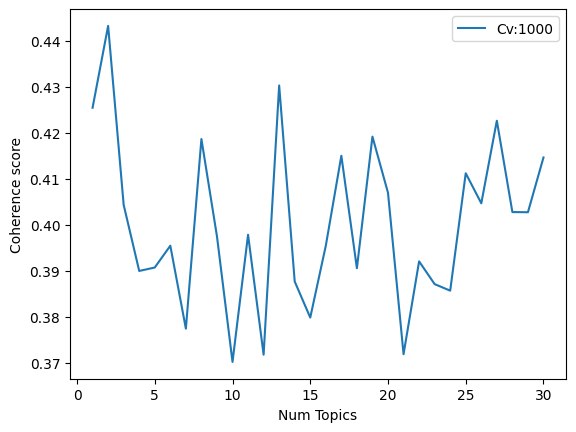

In [190]:
start=1
limit=31
step=1
alpha = 0.1
beta = 0.1
iterations = 1000
model_listuni1000, coherence_valuesuni1000 = compute_LDA_coherence_values(dictionary, corpus=corpus_tfidf,texts=data,start=start, limit=limit, step=step,a=alpha,b=beta,iteration=iterations)
#show graphsCoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_valuesuni1000)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend((["Cv:1000"]), loc='best')
plt.show()

In [ ]:
coherence_valuesuni1000 #0.4878

[0.42549134102206077,
 0.48735689556995876,
 0.43237358456166025,
 0.4878121473895661,
 0.3917912594023957,
 0.4596916318071845,
 0.40210313621429067,
 0.39908655931346265,
 0.38714063301440305,
 0.39979887042960355,
 0.4106910045524883,
 0.38695277538813344,
 0.37803467353614806,
 0.4233997268606288,
 0.37704646724855156,
 0.3853477648886287,
 0.3941370914739429,
 0.38196036292842694,
 0.37623424707438385,
 0.39896863415024997,
 0.39480993976382434,
 0.4015859158013505,
 0.3991349346297698,
 0.3546688688976947,
 0.3904309897662568,
 0.39992648039338,
 0.42060795310759036,
 0.39256077405498085,
 0.412046223241454,
 0.42198511696972296]

In [192]:
model_listuni1000[3].print_topics()

[(0,
  '0.007*"dolar" + 0.004*"suku" + 0.004*"fed" + 0.004*"bunga" + 0.003*"rupiah" + 0.003*"saham" + 0.003*"poin" + 0.003*"bank" + 0.003*"sentral" + 0.003*"indeks"'),
 (1,
  '0.005*"emas" + 0.004*"dolar" + 0.004*"saham" + 0.003*"kamu" + 0.003*"usaha" + 0.002*"minyak" + 0.002*"per" + 0.002*"harga" + 0.002*"gram" + 0.002*"kerja"'),
 (2,
  '0.003*"minyak" + 0.003*"asean" + 0.002*"dolar" + 0.002*"jokowi" + 0.002*"ihsg" + 0.002*"baca" + 0.002*"saham" + 0.002*"dunia" + 0.002*"darurat" + 0.002*"kondisi"'),
 (3,
  '0.005*"minyak" + 0.003*"harga" + 0.003*"bunga" + 0.003*"bank" + 0.003*"suku" + 0.003*"mentah" + 0.003*"inflasi" + 0.002*"kuartal" + 0.002*"baca" + 0.002*"usaha"')]

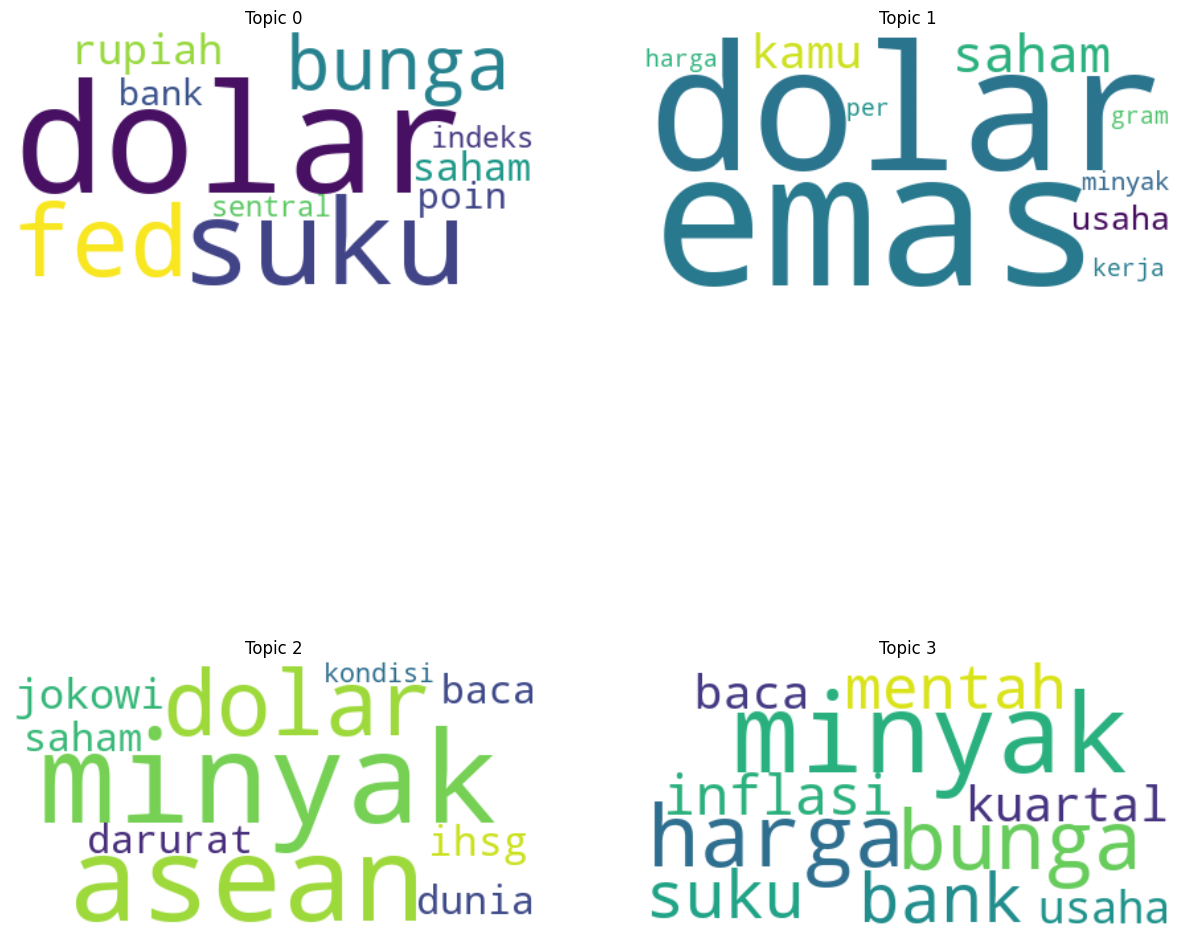

In [193]:
render_word_cloud(model_listuni1000[3], 2, 2, 10)

In [ ]:
print(coherence_valuesuni1000)

[-1.0171842789036878, -1.0852467785730942, -1.0971876869610877, -1.5836925576098362, -1.4863137293481021, -1.9322487186920256, -2.2374167039236674, -2.638114875371662, -2.7171398628995522, -2.148088034908896, -2.2914274380317283, -3.364146460753492, -3.376828760253347, -3.1922794445180753, -2.911419372373873, -3.180540600396774, -4.029150520798069, -4.195567291994048, -3.386783452546367, -3.7898710846749077, -3.6022965810006133, -5.412545242227075, -4.855749720401329, -4.79207272347037, -5.456632470398765, -5.286689737822637, -5.353902961921362, -6.009454110931941, -4.988072392412653, -5.320558234892499]


In [ ]:
coherence_lda = coherence_valuesuni1000[8]
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -1.7325132992968344


 100 iteration

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


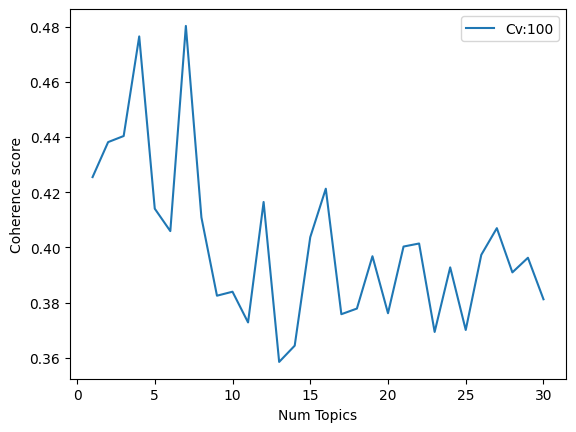

In [ ]:
start=1
limit=31
step=1
alpha = 0.1
beta = 0.1
iterations = 100
model_listuni100, coherence_valuesuni100 = compute_LDA_coherence_values(dictionary, corpus=corpus_tfidf,texts=data,start=start, limit=limit, step=step,a=alpha,b=beta,iteration=iterations)
#show graphsCoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_valuesuni100)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend((["Cv:100"]), loc='best')
plt.show()

In [ ]:
coherence_valuesuni100 #0.48033

[0.42549134102206077,
 0.4381910890950152,
 0.4403984132482606,
 0.47652992207522726,
 0.41404089738466626,
 0.40590296075901816,
 0.48033660921351506,
 0.4108763424418381,
 0.3824698360921264,
 0.3839159993737857,
 0.3727760459969817,
 0.41646984589491015,
 0.3584468038493972,
 0.3643418862036317,
 0.40370198953308123,
 0.4212851190576411,
 0.37575895142991,
 0.37780231277243526,
 0.3967872660163537,
 0.37610892133205115,
 0.4002991062358002,
 0.4014061063960918,
 0.3693196525205457,
 0.39274640831443475,
 0.37003731759604497,
 0.39729179127161,
 0.4069717322740714,
 0.39092993372747525,
 0.39623383841245596,
 0.38117534527233704]

Visualisasi


- WORDCLOUD

In [ ]:
plt.plot(x, coherence_valuesuni100)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend((["Umass:100"]), loc='best')
plt.show()

NameError: name 'coherence_values100' is not defined

In [ ]:
def render_word_cloud(model, rows, cols, max_words):
  word_cloud = WordCloud(background_color='white', max_words=max_words, prefer_horizontal=1.0)
  fig, axes = plt.subplots(rows, cols, figsize=(15,15))

  for i, ax in enumerate(axes.flatten()):
      fig.add_subplot(ax)
      topic_words = dict(model.show_topic(i))
      word_cloud.generate_from_frequencies(topic_words)
      plt.gca().imshow(word_cloud, interpolation='bilinear')
      plt.gca().set_title('Topic {id}'.format(id=i))
      plt.gca().axis('off')

  plt.axis('off')
  plt.show()

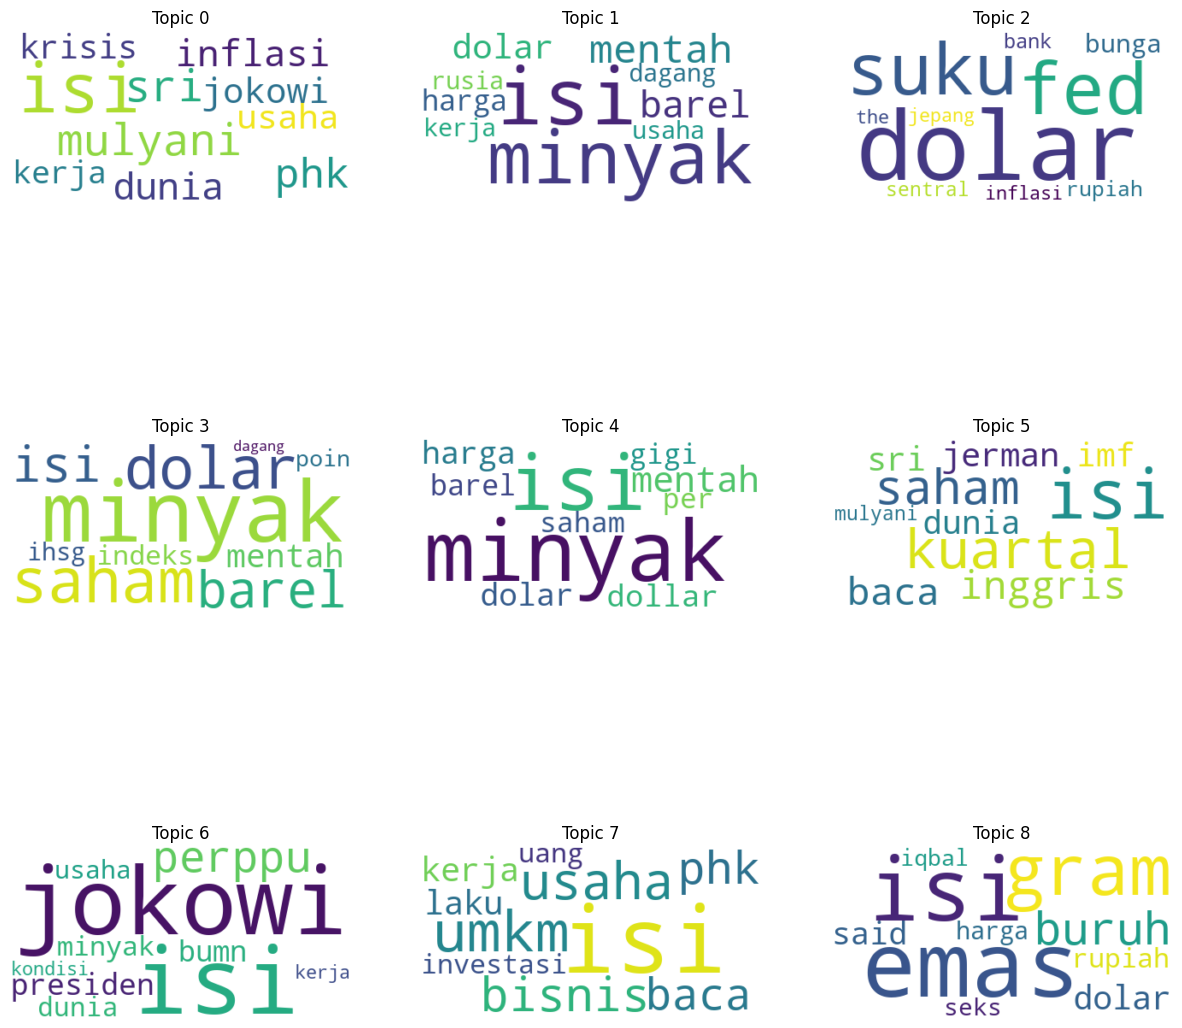

In [ ]:
render_word_cloud(model_list[8], 3, 3, 10)

- PlyDavis

USING BIGRAM

In [ ]:
data_bigram = n_gram(data,2)

In [ ]:
dictionary_bigram = corpora.Dictionary(data_bigram)
print(dictionary)
dictionary_bigram.filter_extremes(no_below=5, no_above=0.2) #filter =  menyaring kata-kata yang muncul di kurang dari N dokumen dan lebih dari M% dokumen.
doc_term_matrix_bigram = [dictionary_bigram.doc2bow(doc) for doc in data_bigram]
tfidf_bigram = models.TfidfModel(doc_term_matrix_bigram) #build TF-IDF model
corpus_tfidf_bigram = tfidf[doc_term_matrix_bigram]

Dictionary<6200 unique tokens: ['acu', 'advertisement', 'advisors', 'agus', 'akhir']...>


In [ ]:
# lda_model_bigram = models.ldamodel.LdaModel(corpus=doc_term_matrix_bigram,
#                                      id2word=dictionary_bigram,
#                                      num_topics=20,
#                                      passes=10,
#                                      iterations = 100000,
#                                      alpha=0.01,
#                                      eta=0.01,
#                                      random_state=1
#                                      )
# lda_model_bigram.print_topics()

iteration 100

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


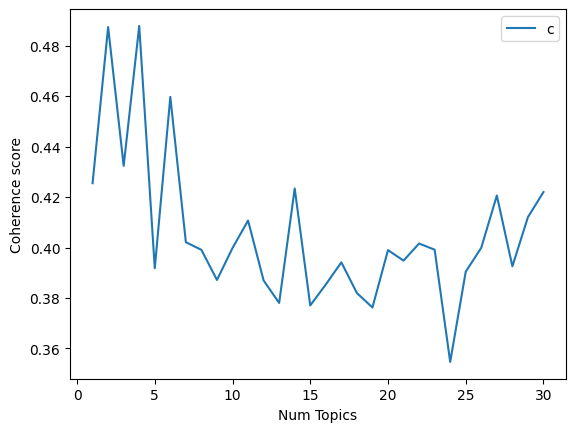

In [ ]:
start=1
limit=31
step=1
alpha = 0.1
beta = 0.1
iterations = 100
model_list100, coherence_values100 = compute_LDA_coherence_values(dictionary_bigram, corpus=corpus_tfidf_bigram,texts=data_bigram,start=start, limit=limit, step=step,a=alpha,b=beta,iteration=iterations)
#show graphsCoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
import matplotlib.pyplot as plt
x = range(start, limit, step)


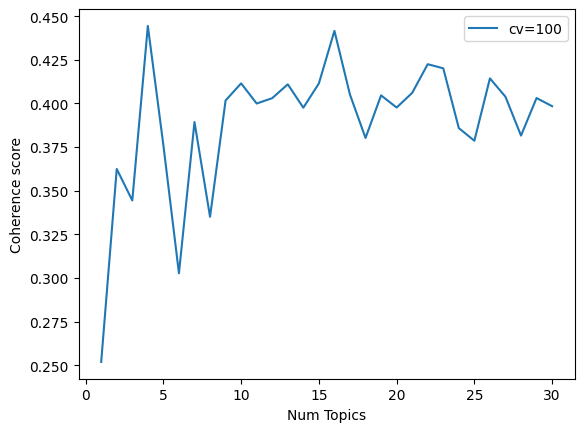

In [ ]:
plt.plot(x, coherence_values100)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend((["cv=100"]), loc='best')
plt.show()

In [ ]:
coherence_values100 #0.4444664582090277

[0.2518436010958496,
 0.3624489109782249,
 0.34440356653757154,
 0.4444664582090277,
 0.3760521600272295,
 0.30266979312463277,
 0.3893572635496759,
 0.3350529622727366,
 0.4017272888134196,
 0.41154577161994543,
 0.3999719277676545,
 0.40306162004336304,
 0.4109922228408281,
 0.3975825065378343,
 0.41149805074614787,
 0.44162408303213346,
 0.40507108090848315,
 0.38023960105426624,
 0.4046531694474731,
 0.39767466521704375,
 0.406078913309378,
 0.4225211307873015,
 0.4201559988096817,
 0.38588785652744056,
 0.3786339016126275,
 0.41439475682991256,
 0.403858591123663,
 0.38159373035901395,
 0.4031280199076118,
 0.39844879797848914]

iteration 500

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


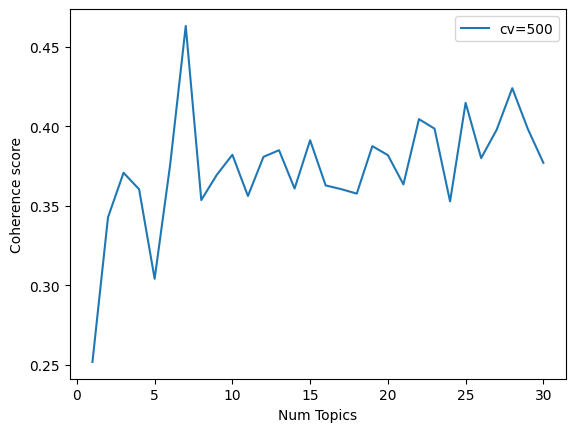

In [ ]:
start=1
limit=31
step=1
alpha = 0.1
beta = 0.1
iterations = 500
model_list500, coherence_values500 = compute_LDA_coherence_values(dictionary_bigram, corpus=corpus_tfidf_bigram,texts=data_bigram,start=start, limit=limit, step=step,a=alpha,b=beta,iteration=iterations)
#show graphsCoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values500)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend((["cv=500"]), loc='best')
plt.show()

In [ ]:
coherence_values500 #0.4632377999893253

[0.2518436010958496,
 0.34278502205703754,
 0.3708534032943047,
 0.3604880244583515,
 0.30413876813227897,
 0.3761265363774471,
 0.4632377999893253,
 0.3536957222519177,
 0.36959125849273344,
 0.38217278864000337,
 0.35623514222452796,
 0.38087104415581635,
 0.38504500008956427,
 0.36093275045819656,
 0.39130023675811854,
 0.36287474402996994,
 0.3605446127529761,
 0.35774650142188025,
 0.38760927291878244,
 0.381937060760814,
 0.3635447586350272,
 0.40457975509278155,
 0.3986223522414688,
 0.3528434823472532,
 0.4148506220335253,
 0.3800729354039868,
 0.39797880350296544,
 0.4240758803061739,
 0.3984516873950316,
 0.3771196365323123]

In [177]:
model_list500[6].print_topics()

[(0,
  '0.004*"ekonomi dunia" + 0.004*"baik indonesia" + 0.004*"resesi ekonomi" + 0.004*"versi forbes" + 0.003*"laku usaha" + 0.003*"hubung kerja" + 0.003*"tenaga kerja" + 0.003*"hadap resesi" + 0.002*"putus hubung" + 0.002*"ekonomi indonesia"'),
 (1,
  '0.003*"per dolar" + 0.002*"minyak mentah" + 0.002*"per barel" + 0.002*"the fed" + 0.001*"nilai tukar" + 0.001*"dolar per" + 0.001*"persen jadi" + 0.001*"poin persen" + 0.001*"akhir tahun" + 0.001*"kuat dolar"'),
 (2,
  '0.006*"dolar per" + 0.006*"minyak mentah" + 0.005*"per barel" + 0.004*"persen jadi" + 0.002*"tenaga kerja" + 0.002*"new york" + 0.002*"sen persen" + 0.002*"per hari" + 0.002*"juta barel" + 0.002*"rata rata"'),
 (3,
  '0.006*"persen jadi" + 0.005*"minyak mentah" + 0.005*"level rendah" + 0.005*"per barel" + 0.005*"imbal hasil" + 0.004*"dolar per" + 0.003*"new york" + 0.003*"naik persen" + 0.003*"bunga lebih" + 0.003*"hasil obligasi"'),
 (4,
  '0.004*"poin persen" + 0.002*"harga saham" + 0.002*"turun poin" + 0.002*"saham g

iteration 1000


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


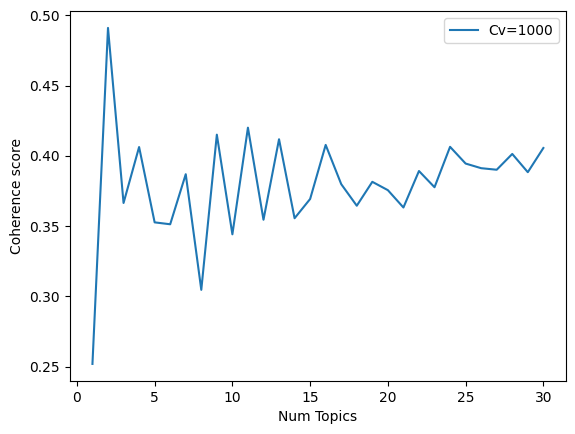

In [ ]:
start=1
limit=31
step=1
alpha = 0.1
beta = 0.1
iterations = 1000
model_listbi1000, coherence_valuesbi1000 = compute_LDA_coherence_values(dictionary_bigram, corpus=corpus_tfidf_bigram,texts=data_bigram,start=start, limit=limit, step=step,a=alpha,b=beta,iteration=iterations)
#show graphsCoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_valuesbi1000)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend((["Cv=1000"]), loc='best')
plt.show()

In [ ]:
coherence_valuesbi1000 #0.491057208849204

[0.2518436010958496,
 0.491057208849204,
 0.3664150794275098,
 0.4062579863707599,
 0.35262542190318164,
 0.351269510649822,
 0.38691129557375026,
 0.30458609660151337,
 0.4150582836485318,
 0.34412231965690365,
 0.4200339866643443,
 0.35448198447955986,
 0.41180596076612636,
 0.3555606350219205,
 0.36927382469331743,
 0.4077653500522511,
 0.37983613672957883,
 0.3644739525159775,
 0.3814896142482384,
 0.37554988747486606,
 0.36321259566722053,
 0.3891786661882948,
 0.377633341675753,
 0.40640623382628344,
 0.3944954622132517,
 0.39119395561932535,
 0.39009305195376165,
 0.401333406499342,
 0.388339523644503,
 0.4055744125128013]

In [178]:
model_listbi1000[1].print_topics()

[(0,
  '0.006*"minyak mentah" + 0.006*"persen jadi" + 0.006*"dolar per" + 0.005*"per barel" + 0.004*"imbal hasil" + 0.004*"level rendah" + 0.003*"new york" + 0.003*"the fed" + 0.003*"lebih rendah" + 0.003*"poin persen"'),
 (1,
  '0.004*"ekonomi dunia" + 0.004*"resesi ekonomi" + 0.004*"laku usaha" + 0.003*"ekonomi indonesia" + 0.003*"tenaga kerja" + 0.003*"alami resesi" + 0.003*"rusia ukraina" + 0.003*"ekonomi nasional" + 0.003*"kerja sama" + 0.003*"tumbuh persen"')]

In [ ]:
start=1
limit=51
step=1
model_list, coherence_values = compute_LDA_coherence_values(dictionary_bigram, corpus=corpus_tfidf_bigram,texts=data_bigram, start=start, limit=limit, step=step)
#show graphsCoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

USING TRIGRAM


In [ ]:
data_trigram = n_gram(data,3)

In [ ]:
data_trigram[0]

['cnn indonesia perintah',
 'indonesia perintah beri',
 'perintah beri insentif',
 'beri insentif bebas',
 'insentif bebas pajak',
 'bebas pajak jual',
 'pajak jual atas',
 'jual atas barang',
 'atas barang mewah',
 'barang mewah ppnbm',
 'mewah ppnbm beli',
 'ppnbm beli mobil',
 'beli mobil baru',
 'mobil baru panjang',
 'baru panjang tahun',
 'panjang tahun ringan',
 'tahun ringan beban',
 'ringan beban masyarakat',
 'beban masyarakat tengah',
 'masyarakat tengah pandemi',
 'tengah pandemi covid',
 'pandemi covid bahkan',
 'covid bahkan mungkin',
 'bahkan mungkin insentif',
 'mungkin insentif pajak',
 'insentif pajak mobil',
 'pajak mobil baru',
 'mobil baru mau',
 'baru mau terus',
 'mau terus tahun',
 'terus tahun depan',
 'tahun depan menteri',
 'depan menteri industri',
 'menteri industri agus',
 'industri agus gumiwang',
 'agus gumiwang kartasasmita',
 'gumiwang kartasasmita tengah',
 'kartasasmita tengah usul',
 'tengah usul menteri',
 'usul menteri uang',
 'menteri uang sri',


In [ ]:
dictionary_trigram = corpora.Dictionary(data_trigram)
print(dictionary_trigram)
dictionary_trigram.filter_extremes(no_below=5, no_above=0.2) #filter =  menyaring kata-kata yang muncul di kurang dari N dokumen dan lebih dari M% dokumen.
doc_term_matrix_trigram = [dictionary_trigram.doc2bow(doc) for doc in data_trigram]
tfidf_trigram = models.TfidfModel(doc_term_matrix) #build TF-IDF model
corpus_tfidf_trigram = tfidf[doc_term_matrix_trigram]

Dictionary<612773 unique tokens: ['acu utama timbang', 'advertisement scroll continue', 'advisors alliance group', 'agus gumiwang kartasasmita', 'akhir korban tabung']...>


In [ ]:
lda_model_trigram = models.ldamodel.LdaModel(corpus=doc_term_matrix_trigram,
                                     id2word=dictionary_trigram,
                                     num_topics=20,
                                     passes=10,
                                     iterations = 100000,
                                     alpha=0.01,
                                     eta=0.01,
                                     random_state=1
                                     )

iteration 100

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


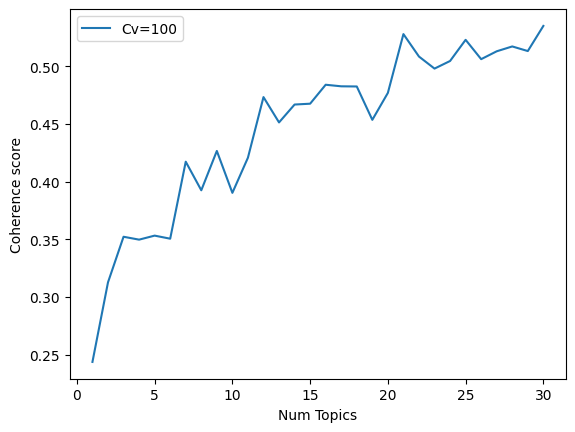

In [ ]:
start=1
limit=31
step=1
alpha = 0.1
beta = 0.1
iterations = 100
model_listtri100, coherence_valuestri100 = compute_LDA_coherence_values(dictionary_trigram, corpus=corpus_tfidf_trigram,texts=data_trigram,start=start, limit=limit, step=step,a=alpha,b=beta,iteration=iterations)
#show graphsCoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_valuestri100)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend((["Cv=100"]), loc='best')
plt.show()

In [ ]:
max(coherence_valuestri100) #0.5349081001053864
coherence_valuestri100

[0.24385148179316568,
 0.3127897941958484,
 0.3522769618573481,
 0.3497732113034042,
 0.35325490084647326,
 0.35059482803586356,
 0.4172957604336497,
 0.3925291798420022,
 0.42660436901882126,
 0.3903078382514409,
 0.42076379375760875,
 0.4732583766448304,
 0.4513120130940791,
 0.4668085698603224,
 0.4675358279575948,
 0.4839557612833122,
 0.48259830715356905,
 0.48245575246474853,
 0.45355014730404986,
 0.4768945826977589,
 0.5278282224142152,
 0.5083744401872112,
 0.49794657445907675,
 0.5045259704250672,
 0.5228697141631069,
 0.5061163039568407,
 0.5129315707666677,
 0.5171294984978612,
 0.5131403514418322,
 0.5349081001053864]

In [172]:
model_listtri100[29].print_topics()

[(3,
  '0.003*"pasar tenaga kerja" + 0.003*"usaha milik negara" + 0.003*"siap dana darurat" + 0.003*"milik negara bumn" + 0.003*"resesi tahun depan" + 0.003*"the fed mungkin" + 0.003*"bumn erick thohir" + 0.002*"benar benar jadi" + 0.002*"banding rata rata" + 0.002*"suku bunga acu"'),
 (11,
  '0.005*"otoritas jasa uang" + 0.004*"jasa uang ojk" + 0.003*"tumbuh ekonomi indonesia" + 0.002*"bidang masing masing" + 0.002*"ancam resesi global" + 0.002*"menteri koordinator bidang" + 0.002*"tengah ancam resesi" + 0.002*"ketidakpastian ekonomi global" + 0.002*"jadi tantang sendiri" + 0.002*"persen indonesia persen"'),
 (12,
  '0.003*"suku bunga acu" + 0.003*"economics and finance" + 0.003*"sen persen jadi" + 0.003*"posisi per dolar" + 0.003*"nilai tukar rupiah" + 0.003*"hubung kerja phk" + 0.003*"center economic and" + 0.002*"and law studies" + 0.002*"masuk jurang resesi" + 0.002*"for development economics"'),
 (0,
  '0.004*"lanjut halaman ikut" + 0.002*"naik upah minimum" + 0.002*"ekonomi glob

Iteration 500

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


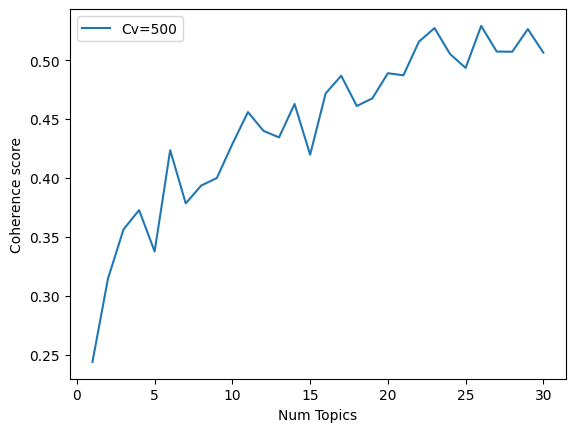

In [164]:
start=1
limit=31
step=1
alpha = 0.1
beta = 0.1
iterations = 500
model_listtri500, coherence_valuestri500 = compute_LDA_coherence_values(dictionary_trigram, corpus=corpus_tfidf_trigram,texts=data_trigram,start=start, limit=limit, step=step,a=alpha,b=beta,iteration=iterations)
#show graphsCoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_valuestri500)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend((["Cv=500"]), loc='best')
plt.show()

In [166]:
max(coherence_valuestri500) #0.5290385292123067
coherence_valuestri500

[0.24385148179316568,
 0.314624337413187,
 0.3563768078456815,
 0.3726916003842403,
 0.3376289292814548,
 0.4235444257554053,
 0.3784281274931577,
 0.3935978925363851,
 0.39991607006170793,
 0.4288028531226365,
 0.45592529798127635,
 0.43995333146879956,
 0.43442847380269467,
 0.46278905560035805,
 0.419728922524699,
 0.4717736784305475,
 0.48675807585645997,
 0.4610857854766936,
 0.4675254210842592,
 0.48889542151735965,
 0.4871316440922324,
 0.5157353342073694,
 0.5272072816040707,
 0.5051734731879564,
 0.493397192535205,
 0.5290385292123067,
 0.507279049183496,
 0.5071260293103369,
 0.5263479971150729,
 0.5063736942455244]

In [174]:
model_listtri500[25].print_topics()

[(7,
  '0.003*"dampak resesi global" + 0.003*"reda khawatir resesi" + 0.003*"suku bunga acu" + 0.002*"nilai tukar rupiah" + 0.002*"bijak moneter global" + 0.002*"jangka ibrahim assuaibi" + 0.002*"year year yoy" + 0.002*"kuartal iii tumbuh" + 0.002*"sejak awal tahun" + 0.002*"forexindo jangka ibrahim"'),
 (13,
  '0.003*"bank sentral eropa" + 0.003*"badan koordinasi tanam" + 0.003*"suku bunga acu" + 0.002*"bkpm bahlil lahadalia" + 0.002*"inflasi lebih rendah" + 0.002*"koordinasi tanam modal" + 0.002*"persen jadi tetap" + 0.002*"pasar negara kembang" + 0.002*"hubung kerja phk" + 0.002*"investasi kepala badan"'),
 (25,
  '0.004*"suku bunga acu" + 0.002*"uang utama lain" + 0.002*"resesi tahun depan" + 0.002*"pengaruh situasi ekonomi" + 0.002*"semua pihak tetap" + 0.002*"lebih rendah banding" + 0.002*"tingkat tumbuh ekonomi" + 0.002*"nilai tukar rupiah" + 0.002*"ekonomi masuk resesi" + 0.002*"tahun tahun belum"'),
 (16,
  '0.009*"naik persen jadi" + 0.007*"hasil obligasi perintah" + 0.007*"i

iteration 1000

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


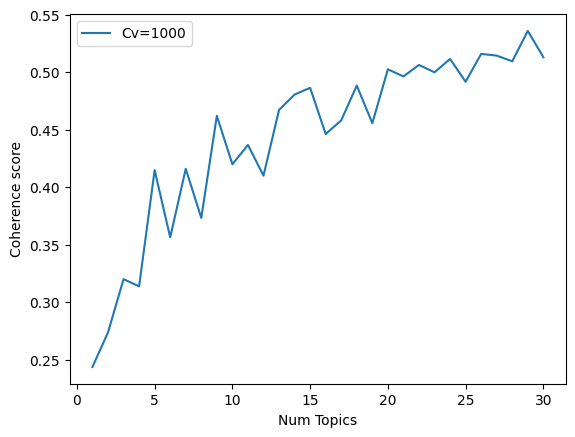

In [167]:
start=1
limit=31
step=1
alpha = 0.1
beta = 0.1
iterations = 1000
model_listtri1000, coherence_valuestri1000 = compute_LDA_coherence_values(dictionary_trigram, corpus=corpus_tfidf_trigram,texts=data_trigram,start=start, limit=limit, step=step,a=alpha,b=beta,iteration=iterations)
#show graphsCoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_valuestri1000)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend((["Cv=1000"]), loc='best')
plt.show()

In [169]:
max(coherence_valuestri1000) #0.5361000687019551
coherence_valuestri1000

[0.24385148179316568,
 0.27384290641155923,
 0.32019614964708665,
 0.31391705169818157,
 0.4150223728305754,
 0.3565373480409056,
 0.41615442246580164,
 0.37342905620818123,
 0.46220148231405034,
 0.42013341080422417,
 0.4369111574408532,
 0.41020257315136277,
 0.46735824895395284,
 0.48075453697988024,
 0.4866108503619103,
 0.44640512279908473,
 0.4583297842401434,
 0.48857482373496985,
 0.45581398906856746,
 0.5026973882188762,
 0.4965343093736667,
 0.5065115396272072,
 0.5000869460731326,
 0.5117292796044083,
 0.49187847365849235,
 0.5161070387418121,
 0.5146156584114537,
 0.509701553561925,
 0.5361000687019551,
 0.5132627983050556]

In [ ]:
lda_model_trigram.print_topics()

[(0,
  '0.016*"dolar per barel" + 0.010*"suku bunga lebih" + 0.008*"nminyak mentah jangka" + 0.007*"sen persen jadi" + 0.007*"dagang dolar per" + 0.007*"terjemah apep suhendar" + 0.007*"mentah jangka brent" + 0.006*"jadi dagang dolar" + 0.006*"dagang asia jumat" + 0.006*"bunga lebih tinggi"'),
 (1,
  '0.022*"poin persen jadi" + 0.012*"suku bunga acu" + 0.008*"jones industrial average" + 0.008*"dow jones industrial" + 0.008*"juta gram juta" + 0.008*"indeks komposit nasdaq" + 0.007*"jadi tetap poin" + 0.007*"nindeks dow jones" + 0.007*"jadi akhir poin" + 0.007*"jadi tutup poin"'),
 (2,
  '0.018*"dolar per barel" + 0.014*"harga minyak mentah" + 0.012*"dolar persen jadi" + 0.012*"nminyak mentah jangka" + 0.011*"texas intermediate wti" + 0.011*"west texas intermediate" + 0.011*"intermediate wti kirim" + 0.010*"jangka brent kirim" + 0.010*"minyak mentah jangka" + 0.009*"jangka west texas"'),
 (3,
  '0.011*"tumbuh ekonomi indonesia" + 0.009*"jadi salah satu" + 0.008*"badan pusat statistik" + 

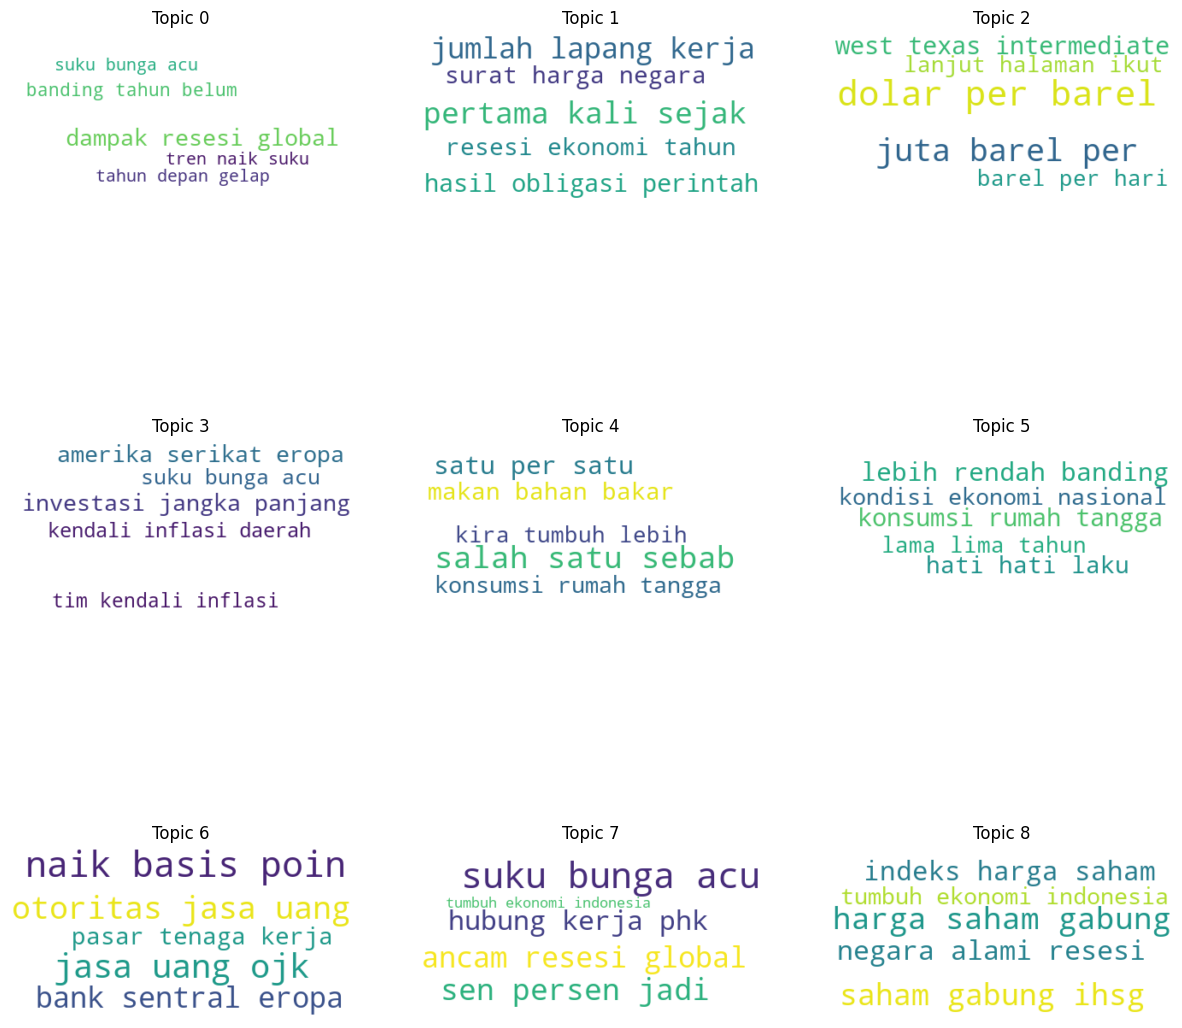

In [185]:
render_word_cloud(model_listtri1000[28], 3, 3, 5)

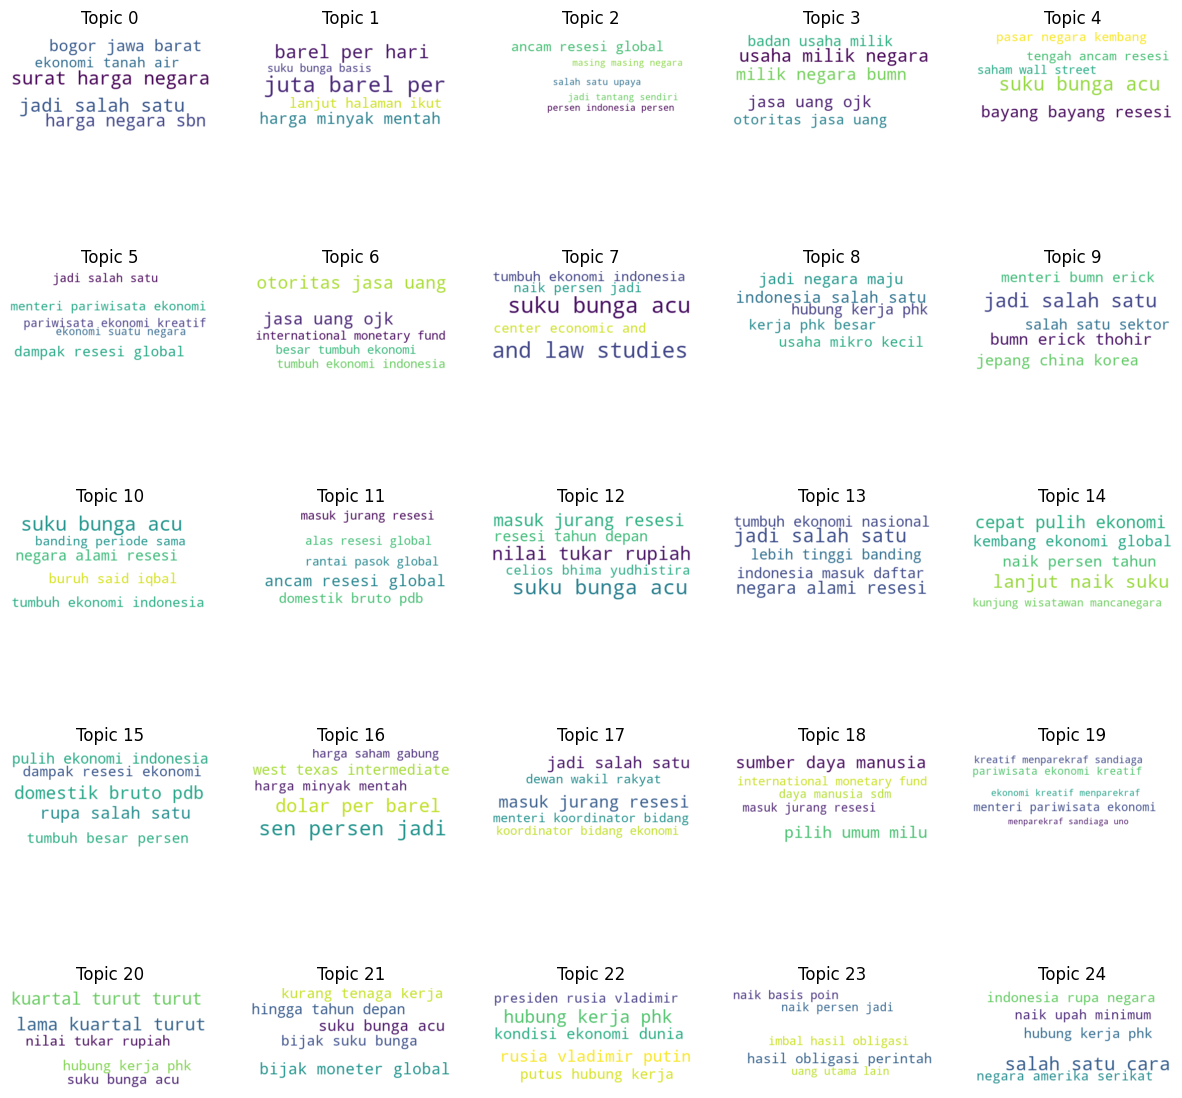

In [187]:
render_word_cloud(model_listtri1000[26], 5, 5, 5)

In [ ]:
start=1
limit=31
step=1
alpha = 0.1
beta = 0.1
iterations = 1000
model_list, coherence_values = compute_LDA_coherence_values(dictionary_trigram, corpus=corpus_tfidf_trigram,texts=data_trigram,start=start, limit=limit, step=step,a=alpha,b=beta,iteration=iterations)
#show graphsCoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

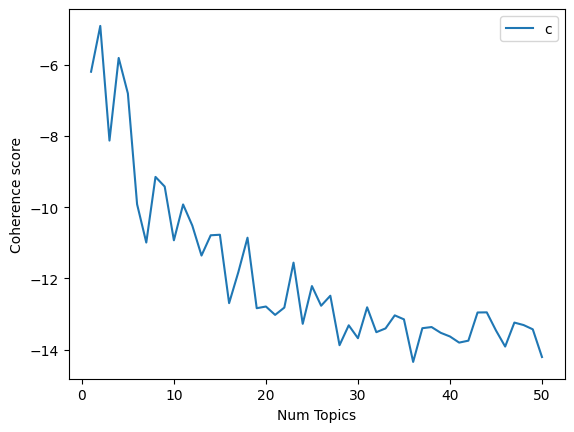

In [ ]:
start=1
limit=51
step=1
model_list, coherence_values = compute_LDA_coherence_values(dictionary_trigram, corpus=corpus_tfidf_trigram,texts=data_trigram, start=start, limit=limit, step=step)
#show graphsCoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()